In [1]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

import stg_energy.fig3_active_subspaces.viz as viz
from pyloric import create_prior, simulate, summary_stats

from stg_energy.common import col, get_labels_8pt, svg

# Figure 3: additional nets
Here, we train 3 nets to predict the energy in AB/PD, LP, and PY. This will be used in fig5_cc

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_quality_of_approx_LinReg = "../svg/panel_quality_of_approx_LinReg.svg"
PANEL_REG_D1_lin = "../svg/panel_reg_d1_lin.svg"
PANEL_REG_D2_lin = "../svg/panel_reg_d2_lin.svg"
PANEL_REG_D3_lin = "../svg/panel_reg_d3_lin.svg"
PANEL_REG_D4_lin = "../svg/panel_reg_d4_lin.svg"
PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_lin_reg = "../svg/panel_lin_reg.svg"
PANEL_REG_supp_bar = "../svg/panel_reg_supp_bar.svg"

### Load experimental data

In [4]:
# prior_11 = create_prior()
# dimensions_11 = 31
# lims_11 = np.asarray(
#     [-np.sqrt(3) * np.ones(dimensions_11), np.sqrt(3) * np.ones(dimensions_11)]
# ).T

# params_mean_11 = prior_11.mean.numpy()
# params_std_11 = prior_11.stddev.numpy()

In [5]:
# data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")

theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [6]:
sample_params = theta_np
sample_stats = x_np
print("There are", len(sample_stats), "datapoints in this dataset")

There are 35939 datapoints in this dataset


In [7]:
# sample_stats = data["sample_stats"]
# sample_params = data["sample_params"]
# sample_seeds = data["sample_seeds"]

In [8]:
energies = x['energies'].to_numpy()
summed_energies = np.sum(energies, axis=1)

# Panel 0: Fit regression net

In [9]:
energies = torch.as_tensor(energies)
sample_stats = torch.as_tensor(sample_stats)

In [10]:
print(energies.shape)

torch.Size([35939, 3])


In [11]:
num_test = 500

test_params = sample_params[:num_test]
train_params = sample_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [12]:
train_energy_ABPD = torch.sum(energies[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(energies[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
regressor = LinearRegression()

In [15]:
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)

In [16]:
predictions = fitted_reg.predict(test_params_norm)

In [17]:
mean_energy

tensor(144816.1214, dtype=torch.float64)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


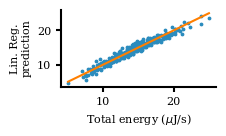

In [18]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y/10/1000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy())/10/1000, np.max(unnorm_x.numpy())/10/1000, 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Lin. Reg.\nprediction")
    plt.savefig(PANEL_quality_of_approx_LinReg, facecolor='None', transparent=False)

In [19]:
unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
mse = np.mean(np.abs(unnorm_x.numpy()/10/1000 - unnorm_y/10/1000)**2)
print("mean squared error: ", mse)

mean squared error:  0.657416062903956


## Bar plot of error

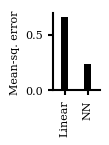

In [39]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.6, 1.0))
    mse_nn = 0.2359 # see notebook 02_build_figure.ipynb
    ax.bar(np.arange(2), [mse, mse_nn], facecolor='k', width=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Mean-sq. error")
    ax.set_xticks([0.0, 1.0])
    ax.set_xlim([-0.5, 1.5])
    ax.set_xticklabels(['Linear', 'NN'], rotation=90)
    plt.savefig(PANEL_REG_supp_bar, facecolor='None', transparent=False)

In [40]:
coeff = np.asarray([fitted_reg.coef_[0]])

In [49]:
coeff

array([[ 0.24303071,  0.24220291,  0.25153375, -0.21448094,  0.02655724,
        -0.09030609, -0.00697747, -0.02183089,  0.06547017,  0.12123624,
         0.287269  , -0.13600494, -0.00704021, -0.08904509,  0.01923243,
        -0.03653325,  0.48822507,  0.59176433,  0.3121119 , -0.24282616,
        -0.14572088, -0.12484712,  0.02081097, -0.08535334,  0.03766614,
        -0.01341674, -0.02270406,  0.03935962,  0.01      , -0.01831952,
         0.08271178]], dtype=float32)

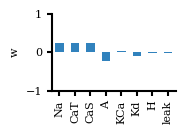

In [50]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 0:8], ylim=[-1, 1], figsize=(1.6, 1.0), ylabel='w', plot_labels=True, color="#3182bd")
    plt.savefig(PANEL_REG_D1_lin, facecolor='None', transparent=False)

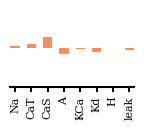

In [51]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 8:16], ylim=[-1, 1], figsize=(1.6, 1.0), ylabel='', plot_labels=False, color="#fc8d59")
    plt.savefig(PANEL_REG_D2_lin, facecolor='None', transparent=False)

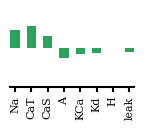

In [52]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 16:24], ylim=[-1, 1], figsize=(1.6, 1.0), ylabel='', plot_labels=False, color="#2ca25f")
    plt.savefig(PANEL_REG_D3_lin, facecolor='None', transparent=False)

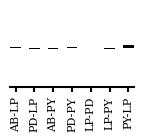

In [60]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(torch.as_tensor(coeff[:1, 24:]), ylim=[-1, 1], figsize=(1.6, 1.0), ylabel=None, color="k")
    plt.savefig(PANEL_REG_D4_lin, facecolor='None', transparent=False)

In [61]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [73]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "7.1cm",

    Panel(
          SVG(PANEL_lin_reg).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -2*factor_svg, -0.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 3.0*factor_svg),

    Panel(
          SVG(PANEL_quality_of_approx_LinReg).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -2*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(36.1*factor_svg, 1.0*factor_svg),

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(73*factor_svg, 0.7*factor_svg),

    Panel(
          SVG(PANEL_REG_supp_bar).scale(svg_scale).move(0, 0*factor_svg),
        Text("c", -1.6*factor_svg, 2.0*factor_svg, **kwargs_text),
    ).move(117*factor_svg, 0.5*factor_svg),

    Panel(
          SVG(PANEL_REG_D1_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("d", -2*factor_svg, -1.0*factor_svg, **kwargs_text),
        Text("AB/PD", 16.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, 26*factor_svg),

    Panel(
          SVG(PANEL_REG_D2_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("LP", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(33*factor_svg, 26.7*factor_svg),

    Panel(
          SVG(PANEL_REG_D3_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("PY", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(58*factor_svg, 26.7*factor_svg),

    Panel(
          SVG(PANEL_REG_D4_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("Synapses", 7.5*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(83*factor_svg, 26.7*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig3_supp4.svg")
svg('../fig/fig3_supp4.svg')